In [27]:
import json
import numpy as np
from tqdm.notebook import tqdm
import chromadb
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import time

# LVD Filtering Benchmark on HNM dataset

The notbook uses [H&M](https://github.com/qdrant/ann-filtering-benchmark-datasets?tab=readme-ov-file) dataset encoded with Efficientnet for experiments. Original the data is from [Kaggle](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data). 

## Load data

In [2]:
# File paths
dir_path = "data/hnm/"
vectors_path = dir_path + "vectors.npy"
payloads_path = dir_path + "payloads.jsonl"
tests_path = dir_path + "tests.jsonl"

# Load vectors as numpy array
vectors = np.load(vectors_path)

# Load payloads.jsonl as python list
with open(payloads_path, 'r') as file:
    payloads = [json.loads(line) for line in file]

# Load tests.jsonl as python list
with open(tests_path, 'r') as file:
    tests = [json.loads(line) for line in file]

(vectors.shape, len(payloads), len(tests))


((105100, 2048), 105100, 10000)

### Check whether filter have same format and preprocess dataset

In [3]:
# Check whether all filter conditions have same format
def check_conditions_format(queries):
    # Define the format for comparison
    required_format = {'and': [{'some_str': {'match': {'value': 'some_str'}}}]}

    # Check each query's conditions format
    for query in queries:
        conditions = query.get('conditions', {})
        # Check the outermost keys
        if list(conditions.keys()) != ['and']:
            return False
        # Check the inner structure
        for condition in conditions['and']:
            if len(condition) > 1:
                return False
            if not isinstance(condition, dict) or len(condition) != 1:
                return False
            for key, value in condition.items():
                if not isinstance(value, dict) or list(value.keys()) != ['match']:
                    return False
                if list(value['match'].keys()) != ['value']:
                    return False
    return True

check_conditions_format(tests)

True

In [4]:
def preprocess_payloads(payloads):
    """
    Preprocess payloads replacing None values with the string 'None'.
    :param payloads: A list of payload entries
    :return: The preprocessed list of payloads
    """
    for payload in payloads:
        for key, value in payload.items():
            if value is None:
                payload[key] = 'None'

preprocess_payloads(payloads)

#### Metadata Example

In [67]:
print(json.dumps(payloads[0], indent=4, sort_keys=True))

{
    "colour_group_code": 31,
    "colour_group_name": "Light Orange",
    "department_name": "Divided Shoes",
    "department_no": 3929,
    "detail_desc": "Ankle boots with lacing at the front, a loop at the back, fabric linings, imitation leather insoles and chunky rubber soles. Platform front 2 cm, heel 4.5 cm.",
    "garment_group_name": "Shoes",
    "garment_group_no": 1020,
    "graphical_appearance_name": "Solid",
    "graphical_appearance_no": 1010016,
    "index_code": "D",
    "index_group_name": "Divided",
    "index_group_no": 2,
    "index_name": "Divided",
    "perceived_colour_master_id": 3,
    "perceived_colour_master_name": "Orange",
    "perceived_colour_value_id": 1,
    "perceived_colour_value_name": "Dusty Light",
    "prod_name": "CHRISTINA BOOT",
    "product_code": 401729,
    "product_group_name": "Shoes",
    "product_type_name": "Boots",
    "product_type_no": 87,
    "section_name": "Divided Accessories",
    "section_no": 52
}


## Setup Database

In [5]:
# Configuration from SISAP 2023 Indexing Challenge - LMI except n_categories
index_configuraiton = {
    "lmi:epochs": "[200]",
    "lmi:model_types": "['MLP-4']",
    "lmi:lrs": "[0.01]",
    "lmi:n_categories": "[20]",
    "lmi:kmeans": "{'verbose': False, 'seed': 2023, 'min_points_per_centroid': 1000}",
}

In [6]:
client = chromadb.Client()

collection_name = "synthetic_collection"
collection = client.create_collection(
    name=collection_name,
    metadata=index_configuraiton
)

### Load data in batches

In [7]:
batch_size = 40000
dataset_size = vectors.shape[0]
for i in tqdm(range(0, dataset_size, batch_size), desc="Adding documents"):
    collection.add(
        embeddings=vectors[i: i + batch_size].tolist(),
        metadatas=payloads[i: i + batch_size],
        ids=[
            str(i) for i in range(i, min(i + batch_size, dataset_size))
        ]
    )

Adding documents:   0%|          | 0/3 [00:00<?, ?it/s]


            LMI Build Config:
            {
                clustering_algorithms: [<function cluster at 0x000002C0D2C43F70>],
                epochs: [200],
                model_types: ['MLP-4'],
                learning_rate: [0.01],
                n_categories: [20],
            }
             


In [8]:
%%time
bucket_assignment = collection.build_index()

FAISS Kmeans parameters {'verbose': False, 'seed': 2023, 'min_points_per_centroid': 1000}
LMI built with n_buckets_in_index: 20
Time taken to build: 738.0564396381378; Time taken to cluster: 2.412471294403076
CPU times: total: 1h 8min 14s
Wall time: 12min 32s


In [23]:
def plot_bucket_items(data):
    """
    Plot the number of items in each bucket, with optional color coding by cluster.

    Parameters:
    data (DataFrame): The data frame containing the 'id', 'bucket', and 'cluster' columns.
    use_colors (bool): If True, use different colors for each cluster in the visualization.
    """
    # Count the total number of items in each bucket
    bucket_counts = data.groupby('bucket_str').size()
    plot_data = bucket_counts.reset_index(name='count')

    # Create the bar plot without colors
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=plot_data, x='bucket_str', y='count')
    
    plt.title('Number of Items in Each Bucket')
    plt.xlabel('Bucket')
    plt.ylabel('Count')

    # Annotate each bar with the count of elements
    for p in ax.patches:
        bar_height = int(p.get_height())
        if bar_height > 0:  # Only annotate bars with a height greater than zero
            ax.annotate(f'{bar_height}', (p.get_x() + p.get_width() / 2., bar_height),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')


In [21]:
data_buckets = pd.DataFrame([str(i) for i in range(vectors.shape[0])], columns=["id"])
data_buckets['bucket'] = data_buckets['id'].map(lambda x: list(bucket_assignment.get(x, [])))
data_buckets['bucket_str'] = data_buckets['bucket'].apply(lambda x: str(x))

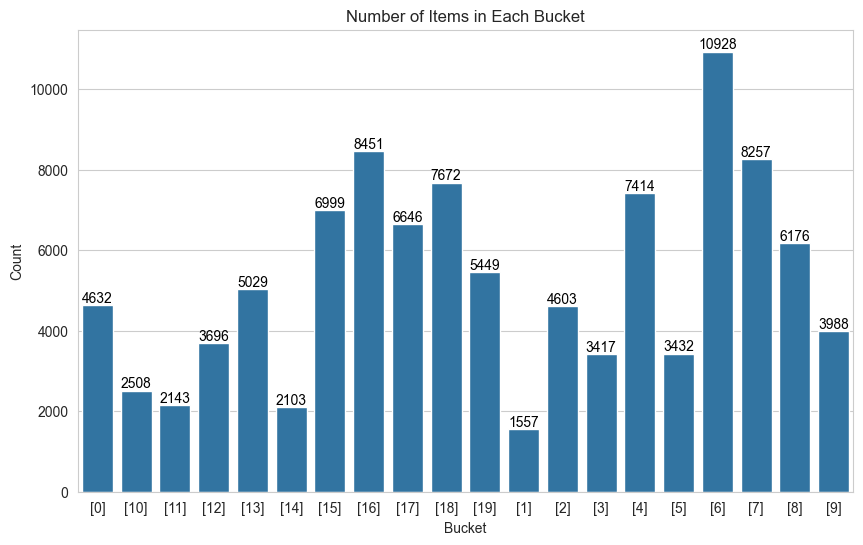

In [24]:
plot_bucket_items(data_buckets)

## Query Database

In [61]:
print('\n ------- Query Example ------- \n')
print('Vector: ' + str(tests[0]['query'][:5]).rstrip("]") + ", ... ]")
print('Constraint: ', tests[0]['conditions'])
print('Ground truth: ', tests[0]['closest_ids'])
print('Closest scores: '+ str(tests[0]['closest_scores'][:5]).rstrip("]") + ", ... ]")


 ------- Query Example ------- 

Vector: [-0.06725436449050903, -0.19710825383663177, 0.3426515758037567, -0.06845792382955551, -0.18674862384796143, ... ]
Constraint:  {'and': [{'product_group_name': {'match': {'value': 'Shoes'}}}]}
Ground truth:  [85488, 102751, 75069, 85976, 8513, 35864, 47721, 12186, 11979, 34106, 50895, 57416, 71679, 38919, 92552, 34113, 37268, 91915, 53456, 71555, 51393, 56265, 76848, 27845, 74693]
Closest scores: [0.31185147166252136, 0.30615049600601196, 0.2900885343551636, 0.28790873289108276, 0.28515058755874634, ... ]


In [9]:
def convert_condition_to_simple_dict(condition):
    key = list(condition['and'][0].keys())[0]  # Extract key from the first item
    value = condition['and'][0][key]['match']['value']  # Extract value from the nested structure
    return {key: value}

def calculate_precision(relevant_ids, retrieved_ids):
    retrieved_ids = set(map(int, retrieved_ids))  # Convert retrieved IDs to integers and remove duplicates
    relevant_ids = set(relevant_ids)  # Remove duplicates
    true_positives = len(relevant_ids & retrieved_ids)
    return true_positives / len(retrieved_ids) if retrieved_ids else 0

In [ ]:
%%time
queries_evaluated = []
lmi_queries = []
lmi_used = 0
total_queries = 100

start = time.time()
for query_id in range(total_queries):
    print("query_id", query_id)
    test_query_object = tests[query_id]
    results = collection.query(
        query_embeddings=test_query_object["query"],
        include=["metadatas",  'distances'],
        where=convert_condition_to_simple_dict(test_query_object["conditions"]),
        n_results=25,
        n_buckets=1,
        constraint_weight=-1,
        bruteforce_threshold=0.1
    )
    if -1 not in results['bucket_order']:
        lmi_queries.append(query_id)
        lmi_used += 1
    queries_evaluated.append(calculate_precision(tests[query_id]["closest_ids"], results['ids'][0]))
end = time.time()
wall_time = end - start

### Evaluation

In [70]:
print('lmi_used', lmi_used)
bruteforce_used = total_queries - lmi_used

lmi_precisions = [queries_evaluated[i] for i in lmi_queries]
print('lmi_average_precision', sum(lmi_precisions) / len(lmi_precisions))
print('lmi_median_precision', statistics.median(lmi_precisions))

lmi_used 25
lmi_average_precision 0.5298666666666666
lmi_median_precision 0.48


In [26]:
# print(queries_evaluated)
indexes = [i for i, val in enumerate(queries_evaluated) if val == 0.0]
print("indexes with zero precision: ", indexes)

indexes with zero precision:  [32]


In [34]:
avg_precision = sum(queries_evaluated) / len(queries_evaluated)
print("Average precision: ", avg_precision)
print("Median precision: ", statistics.median(queries_evaluated))
print("Wall Time ", wall_time)

Average precision:  0.8824666666666668
Median precision:  1.0
Wall Time  102.75298428535461


In [63]:
with open('./chroma_hnsw_hnm_100q.json', 'r') as file:
    chroma_results = json.load(file)

In [36]:
chroma_results['chroma_lmi'] = {}
chroma_results['chroma_lmi']['avg_precision'] = avg_precision
chroma_results['chroma_lmi']['median_precision'] = statistics.median(queries_evaluated)
chroma_results['chroma_lmi']['wall time'] = wall_time

In [37]:
chroma_results

{'chroma_hnsw': {'avg_precision': 0.6628000000000003,
  'median_precision': 0.76,
  'wall time': 77.90504598617554},
 'chroma_lmi': {'avg_precision': 0.8824666666666668,
  'median_precision': 1.0,
  'wall time': 102.75298428535461}}

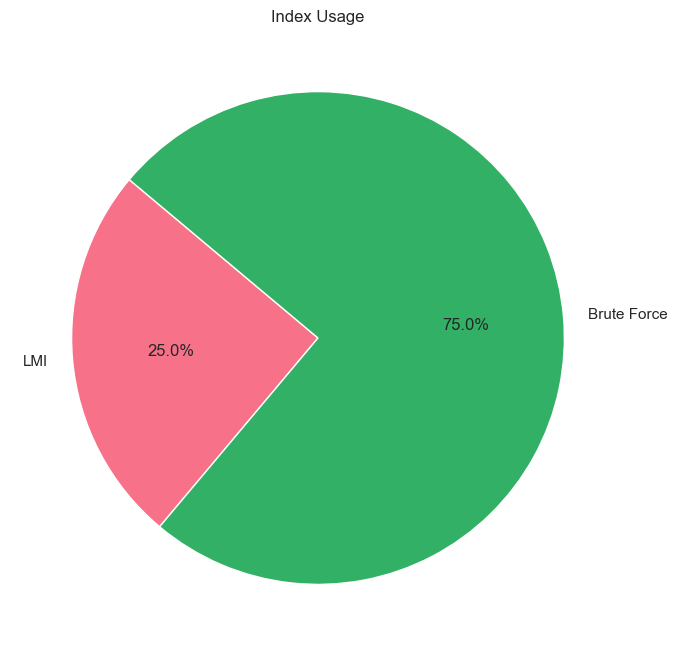

In [75]:
# Setting up the color palette from seaborn specifically for nice purple and green
colors = sns.color_palette("husl", 8)  # Using a color palette with more colors

# Creating the pie chart
plt.figure(figsize=(8,8))
plt.pie([lmi_used, bruteforce_used], labels=["LMI", "Brute Force"], 
        colors=[colors[0], colors[3]],  # Selecting nice colors from the palette (Purple and Green)
        autopct='%1.1f%%', startangle=140)

plt.title('Index Usage')
plt.show()

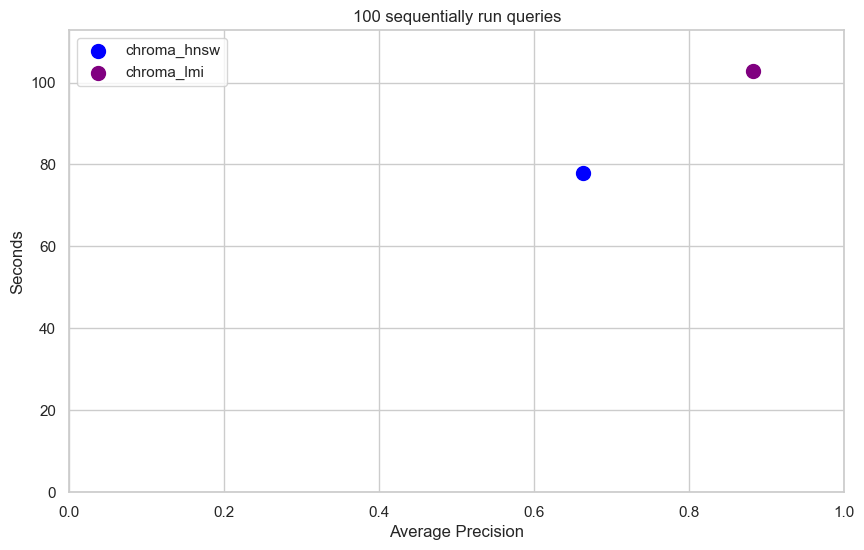

In [44]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Plot each point with round, filled markers and ensure x-axis is from 0 to 1, y-axis starts at 0
for key, value in chroma_results.items():
    color = 'blue' if key == 'chroma_hnsw' else 'purple'
    plt.scatter(value['avg_precision'], value['wall time'], label=key, color=color, s=100)  # s is the size of marker

# Labeling the axes and title
plt.xlabel('Average Precision')
plt.ylabel('Seconds')
plt.title('100 sequentially run queries')
plt.xlim(0, 1)  # Ensuring x-axis covers 0 to 1 range
plt.ylim(0, max(chroma_results['chroma_hnsw']['wall time'], chroma_results['chroma_lmi']['wall time']) + 10)  # Ensuring y-axis starts at 0
plt.legend()

plt.show()